In [9]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, TensorDataset

from copy import deepcopy
import numpy as np
import pandas as pd
import os, glob, cv2

import matplotlib.pyplot as plt
from sklearn import cluster

device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints
root_dir = 'P1_Facial_Keypoints/data/training/'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv('P1_Facial_Keypoints/data/training_frames_keypoints.csv')

fatal: destination path 'P1_Facial_Keypoints' already exists and is not an empty directory.


In [11]:
data.head() #even cols: x-coordinate, odd cols: y-coordinate // total 68 key points

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [13]:
#define dataset class
class FacesDataset(Dataset):
  def __init__(self, df) -> None:
    super().__init__()
    self.df = df
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

  def __len__(self): return len(self.df)

  def __getitem__(self, index):
    image_path = "P1_Facial_Keypoints/data/training/" + self.df.iloc[index, 0]
    img = cv2.imread(image_path, cv2.COLOR_BGR2RGB)/255.
    raw_keypoints = deepcopy(self.df.iloc[index, 1:].tolist())
    x_coords = (np.array(raw_keypoints[0::2])/img.shape[1]).tolist()
    y_coords = (np.array(raw_keypoints[1::2])/img.shape[0]).tolist()
    merged_coords = x_coords + y_coords
    merged_coords = torch.tensor(merged_coords)
    img = self.perprocess_input(img)
    return img, merged_coords

  def perprocess_input(self, img):
    img = cv2.resize(img, (224, 224))
    img = torch.tensor(img).permute(2, 0, 1)
    img = self.normalize(img).float()
    return img.to(device)

  def load_img(self, ix):
        img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[ix,0]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
        img = cv2.resize(img, (224,224))
        return img

In [14]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=101, shuffle=True)

train_dataset = FacesDataset(train_data.reset_index(drop=True))
test_dataset = FacesDataset(test_data.reset_index(drop=True))

train_dataloader = DataLoader(train_dataset, batch_size = 32)
test_dataloader = DataLoader(test_dataset, batch_size = 32)

In [17]:
#define model
def get_model():
  model = models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')
  for param in model.parameters():
    param.requires_grads = False

  model.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 136),
            nn.Sigmoid()
  )
  loss_fn = nn.L1Loss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  return model.to(device), loss_fn, optimizer

In [19]:
def train_batch(imgs, kps, model, loss_fn, optimizer):
  model.train()
  optimizer.zero_grad()

  preds = model(imgs)
  loss = loss_fn(preds, kps.to(device))
  loss.backward()

  optimizer.step()
  return loss.item()

@torch.no_grad()
def validate_batch(imgs, kps, model, loss_fn):
  model.eval()
  preds = model(imgs)
  loss = loss_fn(preds, kps.to(device))
  return preds, loss.item()

In [22]:
VGG_model, loss_fn, optimizer = get_model()

In [23]:
train_loss, test_loss = [], []
n_epochs = 50

for epoch in range(n_epochs):

  epoch_train_loss, epoch_test_loss = [],  []

  for idx, batch in enumerate(train_dataloader):
    imgs, kps = batch
    batch_loss = train_batch(imgs, kps, VGG_model, loss_fn, optimizer)
    epoch_train_loss.append(batch_loss)
  train_loss.append(np.mean(epoch_train_loss))

  for idx, batch in enumerate(test_dataloader):
    imgs, kps = batch
    batch_preds, batch_loss = validate_batch(imgs, kps, VGG_model, loss_fn)
    epoch_test_loss.append(batch_loss)
  test_loss.append(np.mean(epoch_test_loss))

  print(f"Epoch [{epoch+1}] :  Train Loss: {epoch_train_loss[-1]:0.3f}   Test Loss: {epoch_test_loss[-1]:0.3f}")


Epoch [1] :  Train Loss: 0.040   Test Loss: 0.031
Epoch [2] :  Train Loss: 0.033   Test Loss: 0.023
Epoch [3] :  Train Loss: 0.028   Test Loss: 0.017
Epoch [4] :  Train Loss: 0.024   Test Loss: 0.016
Epoch [5] :  Train Loss: 0.023   Test Loss: 0.015
Epoch [6] :  Train Loss: 0.022   Test Loss: 0.017
Epoch [7] :  Train Loss: 0.020   Test Loss: 0.017
Epoch [8] :  Train Loss: 0.019   Test Loss: 0.015
Epoch [9] :  Train Loss: 0.020   Test Loss: 0.014
Epoch [10] :  Train Loss: 0.019   Test Loss: 0.015
Epoch [11] :  Train Loss: 0.018   Test Loss: 0.012
Epoch [12] :  Train Loss: 0.017   Test Loss: 0.015
Epoch [13] :  Train Loss: 0.016   Test Loss: 0.012
Epoch [14] :  Train Loss: 0.016   Test Loss: 0.011
Epoch [15] :  Train Loss: 0.014   Test Loss: 0.011
Epoch [16] :  Train Loss: 0.015   Test Loss: 0.013
Epoch [17] :  Train Loss: 0.016   Test Loss: 0.013
Epoch [18] :  Train Loss: 0.014   Test Loss: 0.010
Epoch [19] :  Train Loss: 0.018   Test Loss: 0.011
Epoch [20] :  Train Loss: 0.013   Test L

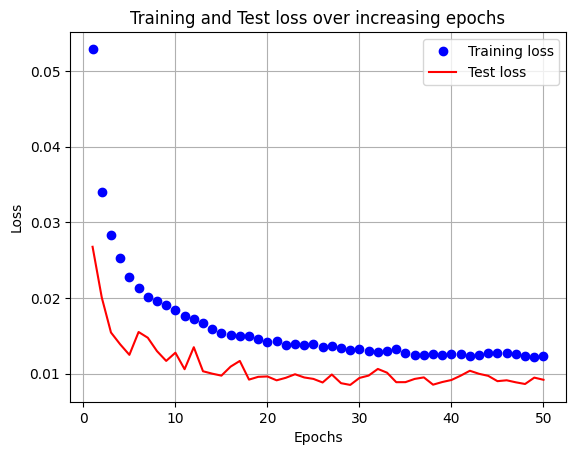

In [24]:
epochs = np.arange(50)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

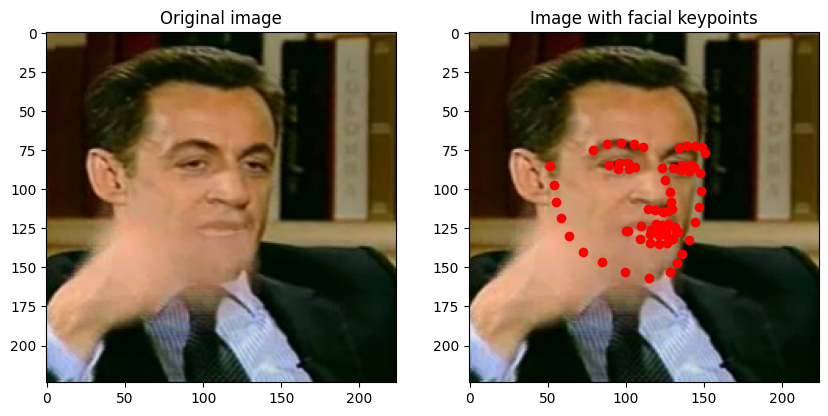

In [25]:
ix = 567
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
im = test_dataset.load_img(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
x, _ = test_dataset[ix]
plt.imshow(im)
kp = VGG_model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()